# Creating Heat Maps to Find Production Month Spikes or Growth Trends

This is an example showing the visual usefulness of heat maps.  Heat maps allow us to quickly identify high quantity items in a table containing a large list of items.  In this demo, I will be obtaining warranty claim data from the database server, create pivot tables that contain top quantity of part #s that failed versus failure month and also versus vehicle build month.  Then create heat maps out of them.  I have utilized notebook widgets so that a user can select a vehicle model year, factory, model name, and vehicle system location.

By looking at quantities versus vehicle build month, I can look for batch problems or determine if a problem is isolated to vehicles built during a certain time period.  By looking at quantities versus failure month, I can look for growth trend or seasonal trends based on when they are failing.

**NOTE:** The SQL, database, and claim data herein were purposely altered or made ficticious to ensure confidentiality.

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

### Prompt user to enter user ID and password:

In [5]:
%matplotlib inline
from ipywidgets import HTML
import matplotlib.pyplot as plt
import pyodbc
from getpass import getpass
import seaborn as sns
import pandas as pd

userid = getpass(prompt='Enter user ID: ')
pw     = getpass(prompt='Enter password: ')

Enter user ID: ········
Enter password: ········


<a id="sql"></a>

### Connect to company database server and execute SQL:

[[By Vehicle Build Month](#by_af)]&nbsp;&nbsp;[[By Failure Month](#by_ro)]

In [6]:
cnxn_string = 'DSN=fake_dsn_name;UID=' + userid + ';PWD=' + pw

cnxn = pyodbc.connect(cnxn_string)
cursor = cnxn.cursor()

sql = """
WITH claims as (
SELECT
CLAIMS.CLM_SK,
CLAIMS.VIN_SK,
CLAIMS.FAIL_PART_SK,
CLAIMS.SUBL_01_SK,
CLAIMS.SUBL_02_SK,
CLAIMS.CAMP_SK,
CLAIMS.RO_DT_SK,
CLAIMS.PRM_LAB_OPRTN_SK,
CLAIMS.REMB_CLM_AMT

FROM CMQ.V_FACT_CLM_TRX CLAIMS

INNER JOIN CMQ.V_DIM_MTO MTO
ON CLAIMS.MTO_SK = MTO.MTO_SK

WHERE
MTO.MDL_YR IN( 2014, 2015 )
AND MTO.FCTRY_CD IN( 'ELP','MAP','HMIN','HMA','HCM', 'HDM', 'HCL' )
AND MTO.DEST_CD IN('KA','KL')
),

vehicles as (
SELECT
PROD.VIN_SK,
PROD.MTO_SK,
PROD.AF_OFF_DT_SK

FROM CMQ.V_FACT_VHCL_PRDN_SLS AS PROD

INNER JOIN CMQ.V_DIM_MTO MTO
ON PROD.MTO_SK = MTO.MTO_SK

WHERE
MTO.MDL_YR IN( 2014, 2015 )
AND MTO.FCTRY_CD IN( 'ELP','MAP','HMIN','HMA','HCM', 'HDM', 'HCL' )
AND MTO.DEST_CD IN('KA','KL')
),

mto as (
SELECT
MTO_SK,
MDL_YR,
FCTRY_CD,
MDL_NM,
DEST_CD,
"ENGINE CYLINDERS" AS ENG_CYL,
"DOORS" AS DOOR_QTY

FROM CMQ.V_DIM_MTO_FEATURE_PIVOT MTO

WHERE
MTO.MDL_YR IN( 2014, 2015 )
AND MTO.FCTRY_CD IN( 'ELP','MAP','HMIN','HMA','HCM', 'HDM', 'HCL' )
AND MTO.DEST_CD IN('KA','KL')
)

SELECT
YEAR,
FACTORY,
MODEL,
PART5_NAME,
AF_YR_MTH,
RO_YR_MTH,
BLO1,
ENG_CYL,
DOOR_QTY,
CBU_LOC_NM,
COUNT(*) AS QTY

FROM (

SELECT
MTO.MDL_YR as YEAR,
MTO.FCTRY_CD as FACTORY,
MTO.MDL_NM as MODEL,
MTO.ENG_CYL,
MTO.DOOR_QTY,
PART.SHRT_PART_NO||' - '||SHRT_PART.PART_DESC AS PART5_NAME,
PART.SHRT_PART_NO AS PART5,
SHRT_PART.PART_DESC AS PART_DESC,
SUBSTR(LABOR.LAB_OPRTN_CD,1,1) AS BLO1,
CBU.CBU_LOC_NM,
AF_CAL.CAL_YR_MO_FMT_NO as AF_YR_MTH,
RO_CAL.CAL_YR_MO_FMT_NO as RO_YR_MTH

FROM claims claims

INNER JOIN vehicles vehicles
ON claims.VIN_SK = vehicles.VIN_SK

INNER JOIN mto mto
on vehicles.MTO_SK = mto.MTO_SK

INNER JOIN CMQ.V_DIM_DATE AF_CAL
ON vehicles.AF_OFF_DT_SK = AF_CAL.CAL_DT_SK

INNER JOIN CMQ.V_DIM_DATE RO_CAL
ON claims.RO_DT_SK = RO_CAL.CAL_DT_SK

INNER JOIN CMQ.V_DIM_CLM CLM_DETAILS
ON claims.CLM_SK = CLM_DETAILS.CLM_SK

INNER JOIN CMQ.V_DIM_PART PART
ON claims.FAIL_PART_SK = PART.PART_SK

INNER JOIN CMQ.V_DIM_SHRT_PART SHRT_PART
ON PART.SHRT_PART_NO = SHRT_PART.SHRT_PART_NO

INNER JOIN CMQ.V_DIM_PART_CBU_LOC_ASSOC CBU
ON claims.FAIL_PART_SK = CBU.PART_SK

INNER JOIN CMQ.V_DIM_SUBL_CD SUBL1
ON claims.SUBL_01_SK = SUBL1.SUBL_CD_SK

INNER JOIN CMQ.V_DIM_SUBL_CD SUBL2
ON claims.SUBL_02_SK = SUBL2.SUBL_CD_SK

INNER JOIN CMQ.V_DIM_LAB_OPRTN_CD LABOR
ON claims.PRM_LAB_OPRTN_SK = LABOR.LAB_OPRTN_SK

WHERE
CAMP_SK <= 0
AND NOT(SUBL1.SUBL_CD = 'GW')
AND NOT(SUBL2.SUBL_CD = 'GW')
AND NOT LEFT(PART.PART_NO,2) = '08'
AND NOT LEFT(CLM_DETAILS.CLM_NO,1) IN('T','R')
AND NOT PART.PART_NO IN('TCHV','TCAV')

) as temp

GROUP BY
YEAR,
FACTORY,
MODEL,
PART5_NAME,
AF_YR_MTH,
RO_YR_MTH,
BLO1,
ENG_CYL,
DOOR_QTY,
CBU_LOC_NM
"""

df = pd.read_sql(sql, cnxn, index_col=None)

# Close connections
cursor.close()
cnxn.close()

<a id="by_af"></a>

### Heat Map of Qty of Claims versus Vehicle Build Month - to find build month trends

[[By Failure Month](#by_ro)]

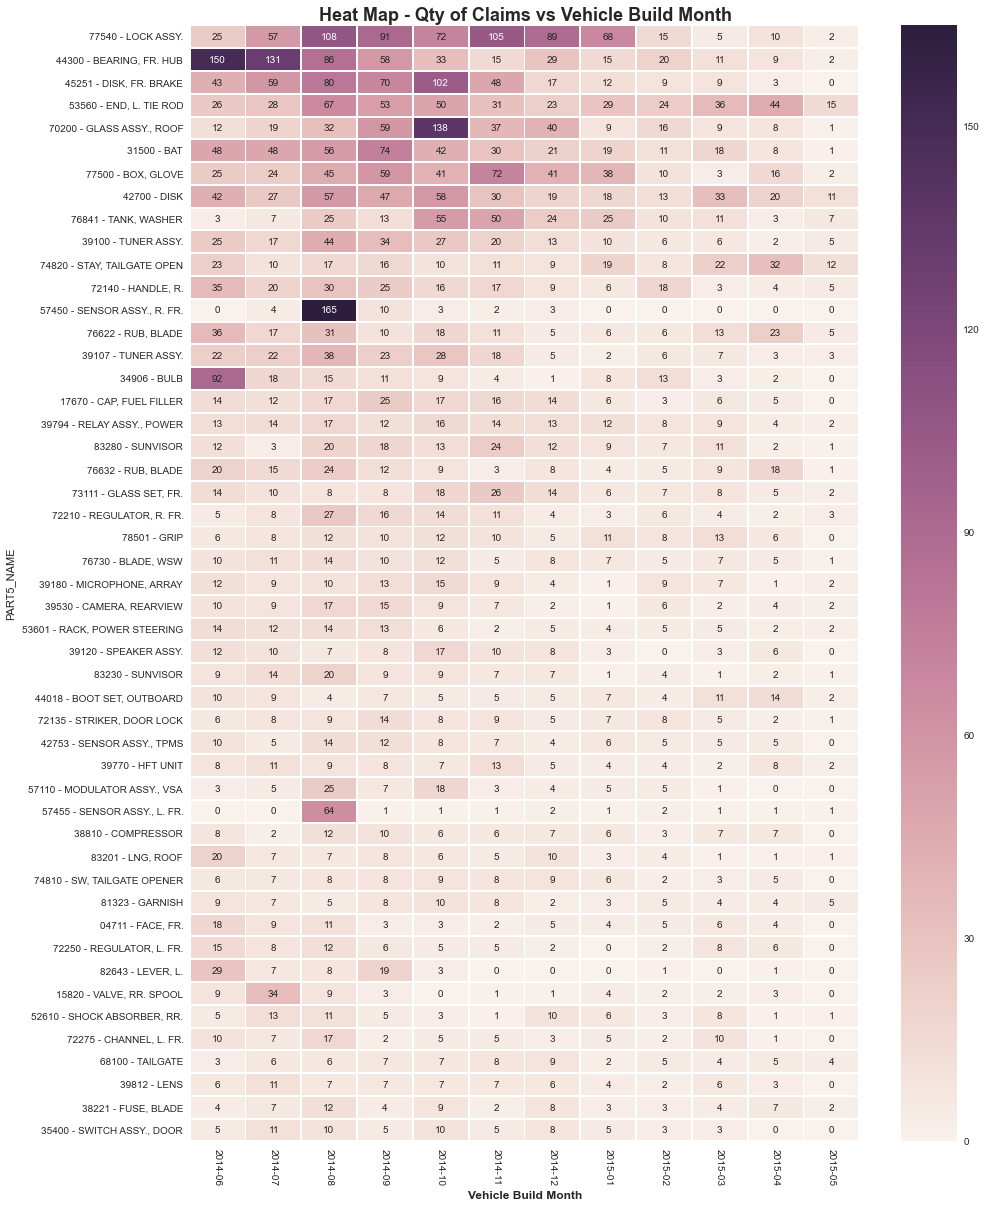

In [7]:
from ipywidgets import interact

# make lists that will be used for the drop down widgets
year_list    = [str(value) for value in df['YEAR'].drop_duplicates().values]
factory_list = [value for value in df['FACTORY'].drop_duplicates().values]
model_list = ['ALL']
models   = [value for value in df['MODEL'].drop_duplicates().values]
models.sort()
for model in models:
    model_list.append(model)
cbu_list = ['ALL']
cbus = [value for value in df['CBU_LOC_NM'].drop_duplicates().values]
cbus.sort()
for value in cbus:
    cbu_list.append(value)
start_value = ['none','1','2','3','4','5','6','7','8','9','10','20','50','100']
end_value   = ['50','100','150','200']

@interact
def heatmap_AF(year=year_list, factory=factory_list, model=model_list, cbu=cbu_list, skip_first=start_value, end=end_value):
    criteria1 = df['FACTORY']==factory
    criteria2 = df['CBU_LOC_NM']==cbu
    criteria3 = df['YEAR']==int(year)
    criteria4 = df['MODEL']==model
    
    if cbu=='ALL' and model=='ALL':
        df_final = df[criteria1 & criteria3]
    elif model=='ALL':
        df_final = df[criteria1 & criteria2 & criteria3]
    elif cbu=='ALL':
        df_final = df[criteria1 & criteria3 & criteria4]
    else:
        df_final = df[criteria1 & criteria2 & criteria3 & criteria4]
    
    try:
        pivot_af = pd.pivot_table(df_final, values="QTY", index="PART5_NAME", columns="AF_YR_MTH", aggfunc="sum", fill_value=0,
                       margins=True)
        pivot_af.sort_values(by='All',ascending=False, inplace=True)
        pivot_af.drop('All',axis='columns',inplace=True)
        pivot_af.drop('All',axis='index',inplace=True)
        fig, ax = plt.subplots(figsize=(15,20))
        if skip_first=='none':
            sns.heatmap(pivot_af[:int(end)], annot=True, fmt='n', linewidths=0.5)
        else:
            sns.heatmap(pivot_af[int(skip_first):int(end)], annot=True, fmt='n', linewidths=0.5)
        plt.title("Heat Map - Qty of Claims vs Vehicle Build Month", fontsize=18, weight='bold')
        plt.xlabel("Vehicle Build Month", fontsize=12, weight='bold')
        plt.xticks(rotation=270)
        plt.show()
    except:
        print('Invalid selection')

<a id='by_ro'></a>

<a id="by_ro"></a>

### Heat Map of Qty of Claims versus Failure Month - to find seasonal trends or growth trends

[[By Vehicle Build Month](#by_af)]

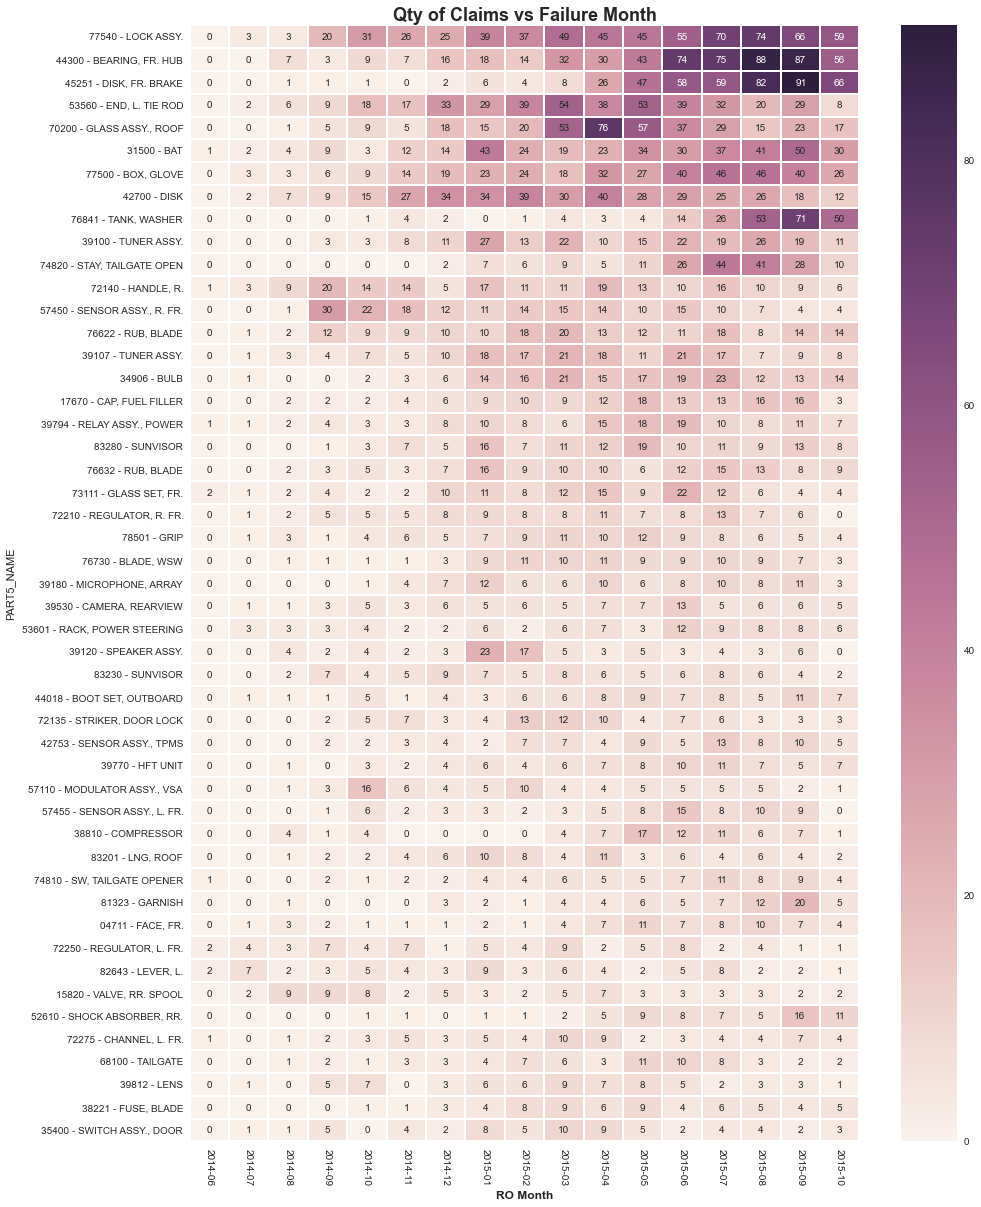

In [8]:
from ipywidgets import interact

# make lists that will be used for the drop down widgets
year_list    = [str(value) for value in df['YEAR'].drop_duplicates().values]
factory_list = [value for value in df['FACTORY'].drop_duplicates().values]
model_list = ['ALL']
models   = [value for value in df['MODEL'].drop_duplicates().values]
models.sort()
for model in models:
    model_list.append(model)
cbu_list = ['ALL']
cbus = [value for value in df['CBU_LOC_NM'].drop_duplicates().values]
cbus.sort()
for value in cbus:
    cbu_list.append(value)
start_value = ['none','1','2','3','4','5','6','7','8','9','10','20','50','100']
end_value   = ['50','100','150','200']

@interact
def heatmap_RO(year=year_list, factory=factory_list, model=model_list, cbu=cbu_list, skip_first=start_value, end=end_value):
    criteria1 = df['FACTORY']==factory
    criteria2 = df['CBU_LOC_NM']==cbu
    criteria3 = df['YEAR']==int(year)
    criteria4 = df['MODEL']==model
    
    if cbu=='ALL' and model=='ALL':
        df_final = df[criteria1 & criteria3]
    elif model=='ALL':
        df_final = df[criteria1 & criteria2 & criteria3]
    elif cbu=='ALL':
        df_final = df[criteria1 & criteria3 & criteria4]
    else:
        df_final = df[criteria1 & criteria2 & criteria3 & criteria4]
    
    try:
        pivot_ro = pd.pivot_table(df_final, values="QTY", index="PART5_NAME", columns="RO_YR_MTH", aggfunc="sum", fill_value=0,
                       margins=True)
        pivot_ro.sort_values(by='All',ascending=False, inplace=True)
        pivot_ro.drop('All',axis='columns',inplace=True)
        pivot_ro.drop('All',axis='index',inplace=True)
        fig, ax = plt.subplots(figsize=(15,20))
        if skip_first=='none':
            sns.heatmap(pivot_ro[:int(end)], annot=True, fmt='n', linewidths=0.5)
        else:
            sns.heatmap(pivot_ro[int(skip_first):int(end)], annot=True, fmt='n', linewidths=0.5)
        plt.title("Qty of Claims vs Failure Month", fontsize=18, weight='bold')
        plt.xlabel("RO Month", fontsize=12, weight='bold')
        plt.xticks(rotation=270)
        plt.show()
    except:
        print('Invalid selection')

#### The bottom heat map above allowed us to see failure quantities for part # 76841 is rising significantly.  The top heat map shows that there appears to be production spikes beginning with October 2014 vehicle build month for part # 76841 as well.  We can also easily see production spikes for the sunroof glass ( # 70200 ) and wheel speed sensor ( # 57450 )

If I were to just look at this table without the shaded color regions that heat maps provide, it would be visually difficult to pick out the top quantities.

**NOTE:** Since this report was made in Oct 2015, the quantities for Oct 2015 failure month should be ignored since it is incomplete data.

<a id='qis'></a>